In [16]:
from time import perf_counter_ns
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, kron, identity
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from openfermionpyscf import run_pyscf
import quimb.tensor as qtn
from convert import to_groups_of
from error_pert import get_v2_sarray
from qpe_trotter import v2_pauli_sum
from kcommute import get_si_sets
from tensor_network_common import pauli_sum_to_mpo, mps_to_vector
from convert import cirq_pauli_sum_to_qiskit_pauli_op

In [10]:
max_mpo_bond = 100
max_mps_bond = 50
energy_error = 1e-3

In [11]:
dmrg_energies = {}
eps2_vals = {}
evol_times = {}
grouping_times = {}
v2_times = {}
expectation_times = {}

for l in [2, 4]:
    print(f"l = {l}")
    bond_length = 1.0 
    natoms = l
    geometry = [("H", (0, 0, i * bond_length)) for i in range(natoms)]
    molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=0)
    molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)  # To get ground state energy for comparison etc., also can use DMRG
    fermion_hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
    ham_jw = of.jordan_wigner(fermion_hamiltonian)
    nterms = len(ham_jw.terms)
    print(f"Hamiltonian has {nterms} terms.")
    ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
    qs = ham_cirq.qubits
    nq = len(qs)
    print(f"Hamiltonian has {nq} qubits.")
    ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
    ham_mpo = pauli_sum_to_mpo(ham_cirq, qs, max_mpo_bond)

    # Get an approximate ground state using DMRG.
    dmrg = qtn.tensor_dmrg.DMRG(ham_mpo, max_mps_bond)
    converged = dmrg.solve()
    if not converged:
        print("DMRG did not converge!")
    ground_state = dmrg.state
    ground_state_vec = mps_to_vector(ground_state)
    ground_energy = dmrg.energy.real
    print(f"Final DMRG energy: {ground_energy:4.5e}")
    dmrg_energies[l] = ground_energy

    if nq <= 16:
        ham_sparse = of.linalg.get_sparse_operator(ham_jw)
        ham_norm = norm(ham_sparse)
    else:
        # Approximate the norm of the Hamiltonian with the triangle inequality.
        # This is an upper bond on the norm, so we will have smaller tau than we should.
        coeffs = np.array([ps.coefficient for ps in ham_cirq])
        ham_norm = np.sum(np.abs(coeffs))
    evol_time = np.pi / (4. * ham_norm)
    print(f"Evolution time = {evol_time}")
    evol_times[l] = evol_time

    start_time = perf_counter_ns()
    groups = get_si_sets(ham_cirq, nq)
    print(f"There are {len(groups)} groups.")
    end_time = perf_counter_ns()
    grouping_time = float(end_time - start_time)

    group_qubops = to_groups_of(groups)
    sparse_frag_ops = []
    # Convert group operators to sparse matrices.
    # We must make sure the matrices have all the same size.
    # If a matrix is not big enough, tensor it with I on the right.
    for op in group_qubops:
        nq_op = of.utils.count_qubits(op)
        op_sparse = of.linalg.get_sparse_operator(op)
        if nq_op != nq:
            eye_diff = identity(2 ** (nq - nq_op), dtype="complex", format='csc')
            new_op = kron(op_sparse, eye_diff, format="csc")
            sparse_frag_ops.append(new_op)
        else:
            sparse_frag_ops.append(op_sparse)
    start_time = perf_counter_ns()
    v2_sparse = get_v2_sarray(sparse_frag_ops)
    end_time = perf_counter_ns()
    v2_time = float(end_time - start_time)
    start_time = perf_counter_ns()
    eps2 = np.vdot(ground_state_vec, v2_sparse @ ground_state_vec).real
    end_time = perf_counter_ns()
    expectation_time = float(end_time - start_time)
    print(f"eps2 = {eps2}")
    eps2_vals[l] = eps2
    grouping_times[l] = grouping_time
    v2_times[l] = v2_time
    expectation_times[l] = expectation_time

l = 2
Hamiltonian has 15 terms.
Hamiltonian has 4 qubits.
sorted_inds = ['k0', 'k1', 'k2', 'k3']
Final DMRG energy: -1.10115e+00
Evolution time = 0.35226189265849644
There are 2 groups.
eps2 = 0.012964855788731803
l = 4
Hamiltonian has 185 terms.
Hamiltonian has 8 qubits.


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in ma

sorted_inds = ['k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7']
Final DMRG energy: -2.16639e+00
Evolution time = 0.054400759887350054
There are 9 groups.
eps2 = 0.032210217622388744


In [12]:
records = []
for l in evol_times.keys():
    records.append((l, dmrg_energies[l], evol_times[l], eps2_vals[l], grouping_times[l], v2_times[l], expectation_times[l]))
df = pd.DataFrame.from_records(records, columns=["l", "dmrg_energy", "evol_time", "eps2", "grouping_time", "v2_time", "expectation_time"])
print(df.head())

   l  dmrg_energy  evol_time      eps2  grouping_time    v2_time  \
0  2    -1.101150   0.352262  0.012965      1639833.0   288791.0   
1  4    -2.166387   0.054401  0.032210     93178333.0  4975292.0   

   expectation_time  
0            7833.0  
1           15625.0  


In [13]:
df["dt"] = np.sqrt(energy_error / np.abs(df["eps2"]))
df["steps"] = np.ceil(df["evol_time"] / df["dt"])

In [14]:
print(df.head())

   l  dmrg_energy  evol_time      eps2  grouping_time    v2_time  \
0  2    -1.101150   0.352262  0.012965      1639833.0   288791.0   
1  4    -2.166387   0.054401  0.032210     93178333.0  4975292.0   

   expectation_time        dt  steps  
0            7833.0  0.277726    2.0  
1           15625.0  0.176199    1.0  


In [15]:
df.to_csv("data/h_chain_results.csv")

Text(0.5, 0, 'l')

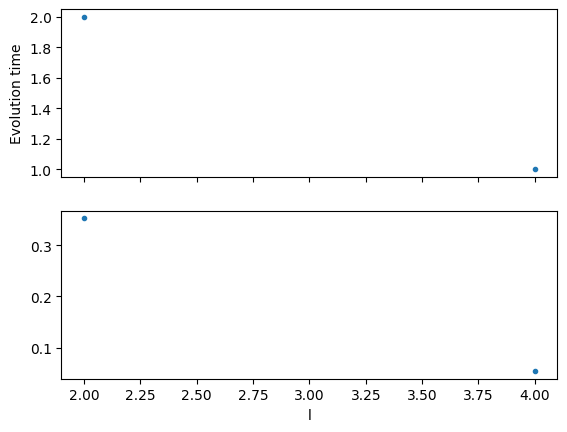

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df["l"], df["steps"], '.')
ax[0].set_ylabel("Number of steps")
ax[1].plot(df["l"], df["evol_time"], '.')
ax[0].set_ylabel("Evolution time")
ax[1].set_xlabel("l")

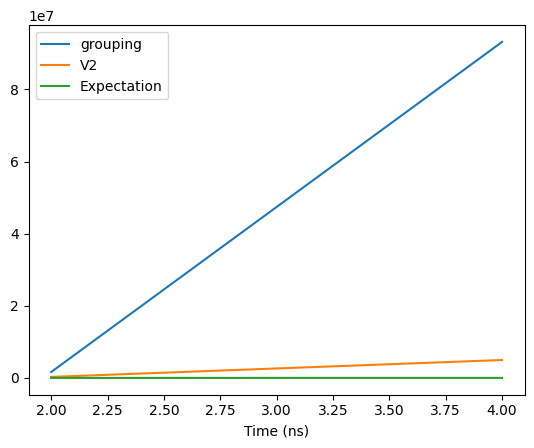

In [21]:
fig2, ax2 = plt.subplots()
ax2.plot(df["l"], df["grouping_time"], label="grouping")
ax2.plot(df["l"], df["v2_time"], label="V2")
ax2.plot(df["l"], df["expectation_time"], label="Expectation")
ax2.set_xlabel("l")
ax2.set_xlabel("Time (ns)")
ax2.legend()